# Voice conversion prototyping

with GMMs; VCTK corpus

using: 
    * p300 American California Female
    * p276 English Oxford Female

In [1]:
# open data
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~"), "Documents/em_lct/UoM/thesis_local/data/VCTK-Corpus", "wav48")
!ls $DATA_ROOT

p225 p232 p240 p248 p255 p262 p269 p276 p283 p293 p301 p308 p316 p333 p343 p363
p226 p233 p241 p249 p256 p263 p270 p277 p284 p294 p302 p310 p317 p334 p345 p364
p227 p234 p243 p250 p257 p264 p271 p278 p285 p295 p303 p311 p318 p335 p347 p374
p228 p236 p244 p251 p258 p265 p272 p279 p286 p297 p304 p312 p323 p336 p351 p376
p229 p237 p245 p252 p259 p266 p273 p280 p287 p298 p305 p313 p326 p339 p360 src
p230 p238 p246 p253 p260 p267 p274 p281 p288 p299 p306 p314 p329 p340 p361 tgt
p231 p239 p247 p254 p261 p268 p275 p282 p292 p300 p307 p315 p330 p341 p362


In [2]:
# nnmnkwii imports taken from example notebook on VC
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os import listdir
from os.path import basename, splitext, join, splitext, isdir
import sys
import time

import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 50 # number of utterances to be used.
test_size = 0.2
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [4]:
def _name_to_dirname(name):
    return join("cmu_us_{}_arctic".format(name), "wav")

class WavFileDataSource():
    """ 
    A modified version of WavFileDataSource from nnmnkwii.
    """
    
    def __init__(self, data_root, speakers, labelmap=None, max_files=None):
        self.data_root = data_root
        self.speakers = speakers
        if labelmap is None:
            labelmap = {}
            for idx, speaker in enumerate(speakers):
                labelmap[speaker] = idx
        self.labelmap = labelmap
        self.max_files = max_files

    def collect_files(self):
        """
        Collects wav files for specific speakers.
        
        Returns:
            list: list of collected wav files.
        """
        
        speaker_dirs = list(
            map(lambda x: join(self.data_root, x),
                self.speakers))
        paths = []
        labels = []

        if self.max_files is None:
            max_files_per_speaker = None
        else:
            max_files_per_speaker = self.max_files // len(self.speakers)
        for (i, d) in enumerate(speaker_dirs):
            if not isdir(d):
                raise RuntimeError("{} doesn't exist.".format(d))
            files = [join(speaker_dirs[i], f) for f in listdir(d)]
            files = list(filter(lambda x: splitext(x)[1] == ".wav", files))
            files = sorted(files)
            files = files[:max_files_per_speaker]
            for f in files:
                paths.append(f)
                labels.append(self.labelmap[self.speakers[i]])

        self.labels = np.array(labels, dtype=np.int32)
        return paths

In [5]:
class MyFileDataSource(WavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        x, fs = librosa.load(path, sr=16000)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [6]:
p300_source = MyFileDataSource(data_root=DATA_ROOT, speakers=["src"], max_files=50)
p276_source = MyFileDataSource(data_root=DATA_ROOT, speakers=["tgt"], max_files=50)

In [7]:
# convert datasets into arrays
X = PaddedFileSourceDataset(p300_source, 2700).asarray()
Y = PaddedFileSourceDataset(p276_source, 2700).asarray()
print(X.shape)
print(Y.shape)

(40, 2700, 25)
(40, 2700, 25)


In [10]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

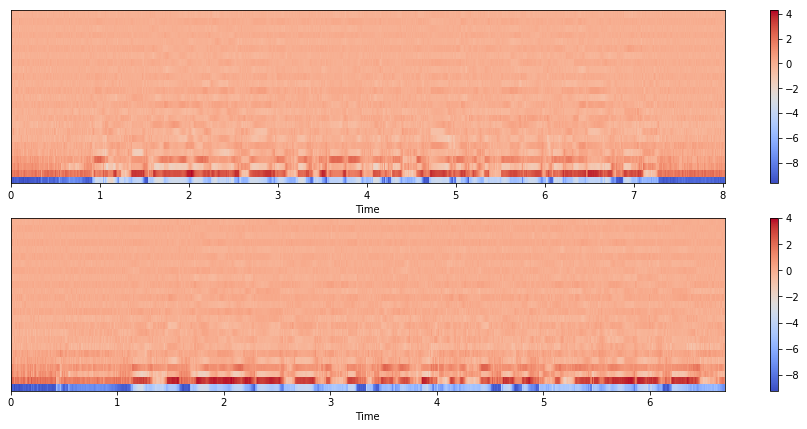

In [11]:
idx = 8 # any 
plot_parallel(X[idx],Y[idx])

In [12]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

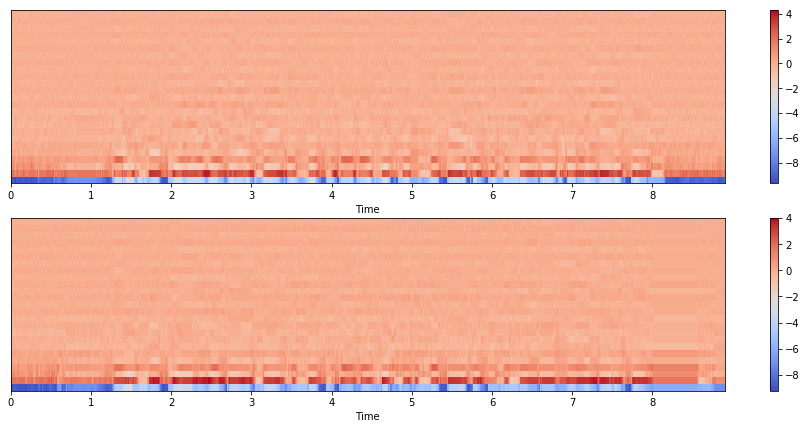

In [13]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [14]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [15]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

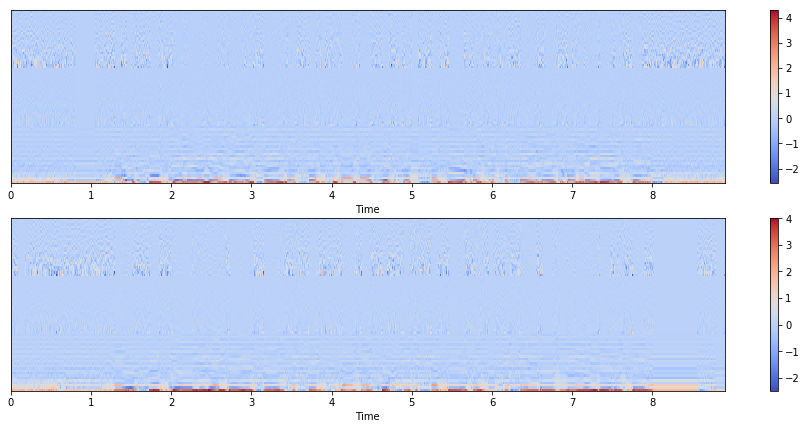

In [16]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [17]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(116200, 144)


In [18]:
XY = remove_zeros_frames(XY)
print(XY.shape)

(50029, 144)


In [19]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
CPU times: user 45min 52s, sys: 4min 18s, total: 50min 10s
Wall time: 12min 49s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

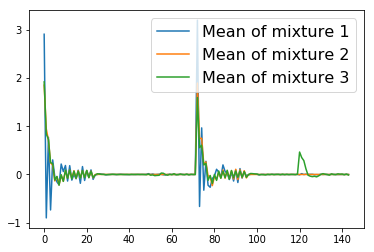

In [20]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

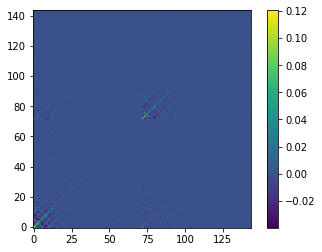

In [21]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

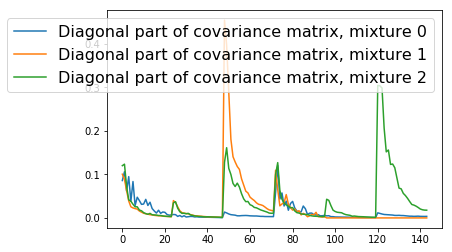

In [22]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5, 
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [23]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    x, fs = librosa.load(src_path, sr=16000)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)
        
    return waveform

Only 3, 5, and 7 are properly parallel

In [24]:
for i, (src_path, tgt_path) in enumerate(zip(p300_source.test_paths, p276_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    src, _ = librosa.load(src_path, sr=16000)
    tgt, _ = librosa.load(tgt_path, sr=16000) 
    
    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

1-th sample
Source: p300_039.wav


Target: p267_039.wav


w/o MLPG


w/ MLPG


2-th sample
Source: p300_047.wav


Target: p267_047.wav


w/o MLPG


w/ MLPG


3-th sample
Source: p300_008.wav


Target: p267_008.wav


w/o MLPG


w/ MLPG


4-th sample
Source: p300_046.wav


Target: p267_046.wav


w/o MLPG


w/ MLPG


5-th sample
Source: p300_015.wav


Target: p267_015.wav


w/o MLPG


w/ MLPG


6-th sample
Source: p300_038.wav


Target: p267_038.wav


w/o MLPG


w/ MLPG


7-th sample
Source: p300_010.wav


Target: p267_010.wav


w/o MLPG


w/ MLPG


8-th sample
Source: p300_031.wav


Target: p267_031.wav


w/o MLPG


w/ MLPG


9-th sample
Source: p300_006.wav


Target: p267_006.wav


w/o MLPG


w/ MLPG


10-th sample
Source: p300_051.wav


Target: p267_051.wav


w/o MLPG


w/ MLPG
